In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [3]:
# Loading the amazon uk price dataset
df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

In [4]:
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


### Part 1: Analyzing Best-Seller Trends Across Product Categories

In [6]:
# Create a crosstab between the product `category` and the `isBestSeller` status.

crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])

crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [7]:
# Are there categories where being a best-seller is more prevalent? 
# Hint: one option is to calculate the proportion of best-sellers for each category
# and then sort the categories based on this proportion in descending order.

# Calculate the total count of items and the count of best-sellers for each category
category_counts = df.groupby('category')['isBestSeller'].agg(['count', 'sum'])

# Calculate the proportion of best-sellers for each category
category_counts['ProportionBestSeller'] = category_counts['sum'] / category_counts['count']

# Sort the categories based on the proportion of best-sellers in descending order
category_counts_sorted = category_counts.sort_values(by='ProportionBestSeller', ascending=False)

print(category_counts_sorted)

                                  count  sum  ProportionBestSeller
category                                                          
Grocery                            9564  556              0.058135
Smart Home Security & Lighting      104    6              0.057692
Health & Personal Care             9569  552              0.057686
Mobile Phone Accessories            259   11              0.042471
Power & Hand Tools                 8659  306              0.035339
...                                 ...  ...                   ...
CD, Disc & Tape Players            8798    0              0.000000
General Music-Making Accessories    259    0              0.000000
Snowboard Boots                    1449    0              0.000000
Boxes & Organisers                  911    0              0.000000
eBook Readers & Accessories         246    0              0.000000

[296 rows x 3 columns]


Grocery,
Smart Home Security & Lighting,
Health & Personal Care,
Mobile Phone Accessories,
Power & Hand Tools,
represent the top 5 of categories where being a best-seller is more prevalent.

In [8]:
# Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.

from scipy.stats import chi2_contingency

# Chi-square test for 'category' and 'isBestSeller'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value

(36540.20270061387, 0.0)

The extremely low p-value (approaching zero) suggests strong evidence against the null hypothesis, indicating that there is a significant association between the best-seller distribution and the product category.

In [9]:
# Compute Cramér's V to understand the strength of association between best-seller status and category.

from scipy.stats.contingency import association

association(crosstab_result, method="cramer")

0.1222829439760564

The Cramér's V value of 0.122 suggests that while there is some association between the categorical variables, it is not particularly strong. 
Therefore, the variables may not have a significant influence on each other.

<Axes: xlabel='category'>

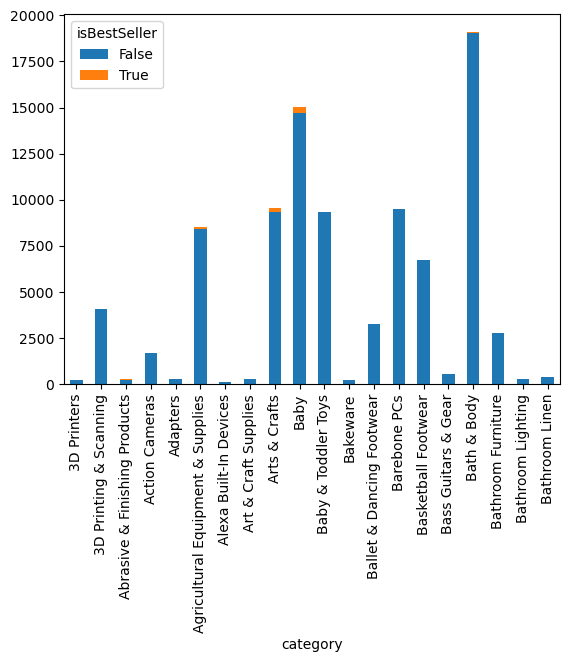

In [10]:
# Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

crosstab_head = crosstab_result.head(20)

crosstab_head.plot(kind="bar", stacked=True)

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

In [11]:
# Preliminary Step: Remove outliers in product prices.

def tukeys_test_remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove the outliers
    cleaned_data = data[(data >= lower_bound) & (data <= upper_bound)]
    
    return cleaned_data

product_prices = df['price']
cleaned_prices = tukeys_test_remove_outliers(product_prices)
df['cleaned_prices']=cleaned_prices

In [12]:
# Which product category tends to have the highest median price? Don't filter here by top categories.

df.groupby('category')['cleaned_prices'].median().sort_values(ascending=False).head(10)
            

category
Desktop PCs               74.00
Boxing Shoes              69.79
Tablets                   69.00
Graphics Cards            68.54
Motherboards              67.92
Made in Italy Handmade    64.00
Digital Frames            63.90
Streaming Clients         62.68
Golf Shoes                62.39
Ski Helmets               61.33
Name: cleaned_prices, dtype: float64

(0.0, 100.0)

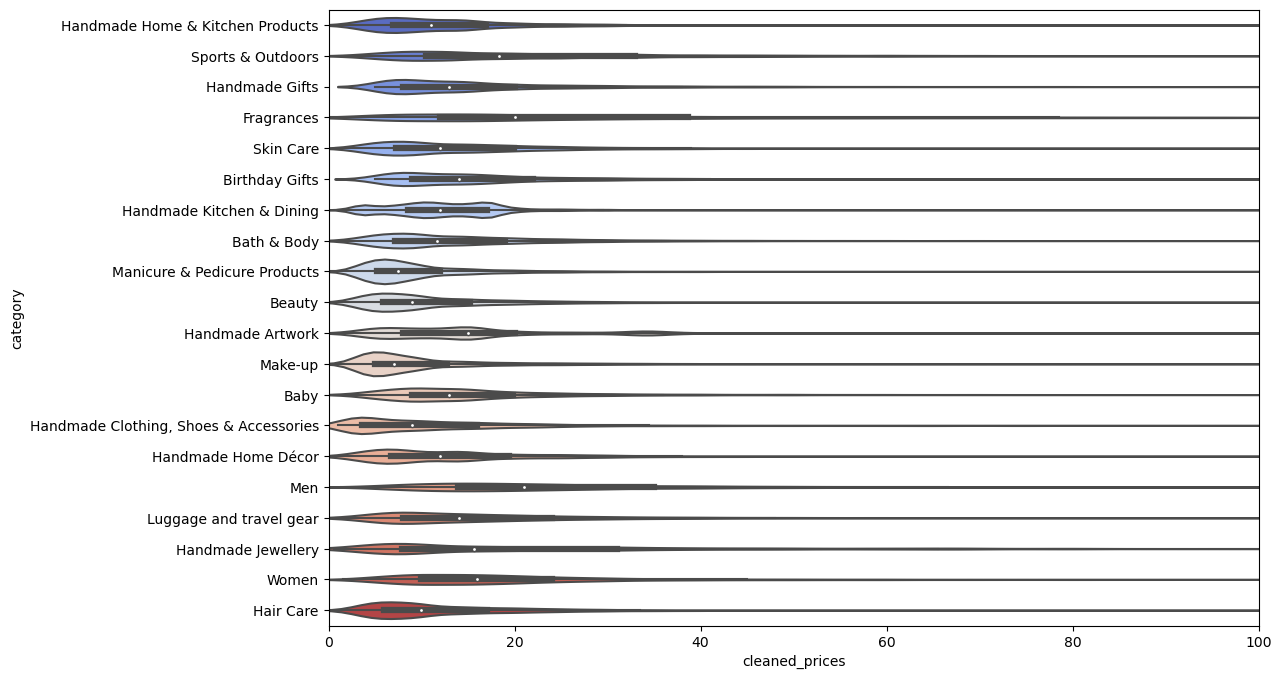

In [14]:
# Use a violin plot to visualize the distribution of `price` across different product `categories`.
# Filter out the top 20 categories based on count for better visualization.

# Count the occurrences of each category
category_counts = df['category'].value_counts()

# Filter out the top 20 categories based on count for better visualization
top_20_categories = category_counts.head(20).index

# Filter the DataFrame to include only the rows corresponding to the top 20 categories
filtered_df = df[df['category'].isin(top_20_categories)]

# Use a violin plot to visualize the distribution of price across these top categories
plt.figure(figsize=(12, 8))
sns.violinplot(data=filtered_df, x='cleaned_prices', y='category', palette="coolwarm", scale='area')
plt.xlim(0, 100)

Text(0, 0.5, 'Product Category')

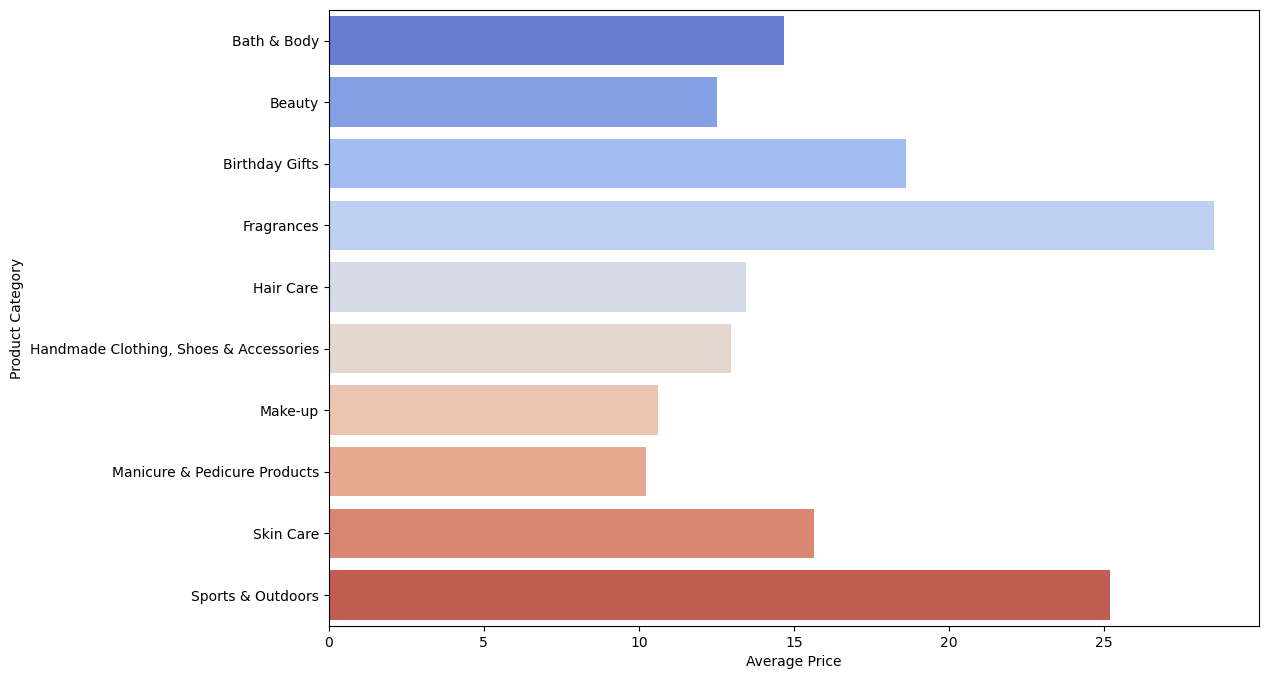

In [15]:
# Create a bar chart comparing the average price of products for the top 10 product categories (based on count).

# Count the occurrences of each category
category_counts = df['category'].value_counts()

# Filter out the top 10 categories based on count
top_10_categories = category_counts.head(10).index

# Filter the DataFrame to include only the rows corresponding to the top 10 categories
filtered_df2 = df[df['category'].isin(top_10_categories)]

# Calculate the average price for each of the top 10 categories
average_price_per_category = filtered_df2.groupby('category')['cleaned_prices'].mean().reset_index()

# Step 5: Create a bar chart to visualize the average price for each category
plt.figure(figsize=(12, 8))
sns.barplot(x='cleaned_prices', y='category', data=average_price_per_category, palette='coolwarm')
plt.xlabel('Average Price')
plt.ylabel('Product Category')

In [129]:
# Which product category commands the highest average price? Don't filter here by top categories

average_price_per_category = df.groupby('category')['cleaned_prices'].mean().reset_index()
highest_avg_price_category = average_price_per_category.loc[average_price_per_category['cleaned_prices'].idxmax()]

print("Category with the highest average price:")
print(highest_avg_price_category)

Category with the highest average price:
category          Motherboards
cleaned_prices       68.772432
Name: 190, dtype: object


<Axes: xlabel='stars', ylabel='category'>

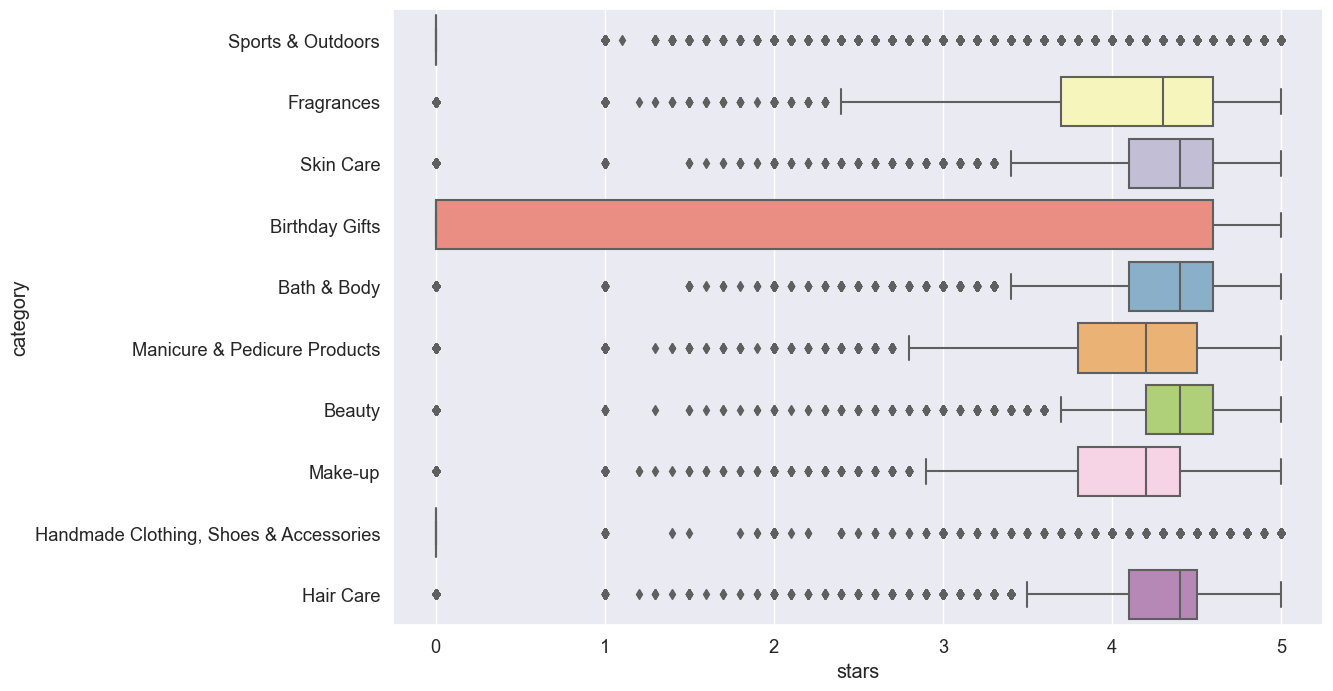

In [139]:
# Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. 
# Filter out the top 10 categories based on count for better visualization = filtered_df2 (see above)

plt.figure(figsize=(12, 8))
sns.boxplot(x='stars', y='category', data=filtered_df2, palette='Set3')


In [140]:
# Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

median_rating_per_category = df.groupby('category')['stars'].median().reset_index()

highest_median_rating_category = median_rating_per_category.loc[median_rating_per_category['stars'].idxmax()]

print("Category with the highest median rating:")
print(highest_median_rating_category)

Category with the highest median rating:
category    Computer Memory
stars                   4.7
Name: 56, dtype: object


### Part 3: Investigating the Interplay Between Product Prices and Ratings

In [141]:
# Calculate the correlation coefficient between `price` and `stars`.

correlation = df['cleaned_prices'].corr(df['stars'])
correlation

-0.07767299878181444

 The correlation coefficient of approx. -0.077 suggests a weak negative relationship between the price of product and its corresponding rating.

<Axes: xlabel='stars', ylabel='cleaned_prices'>

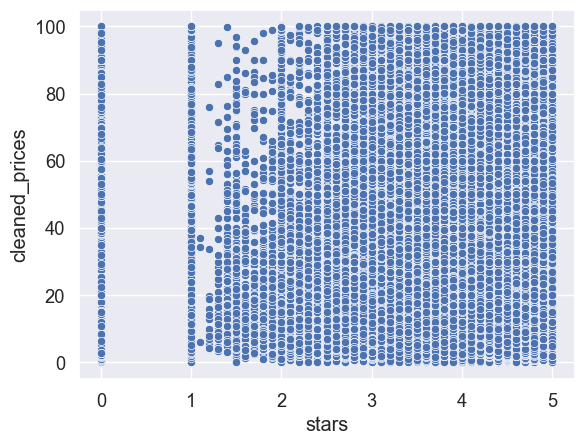

In [144]:
# Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
sns.scatterplot(data=df, x='stars', y='cleaned_prices')

There is no correlation between product price and its rating.

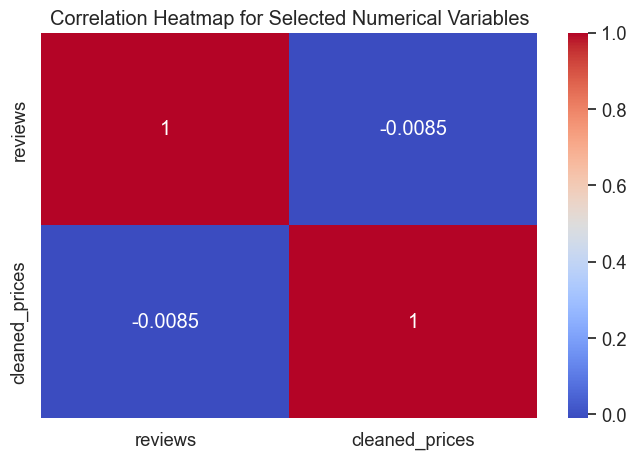

In [154]:
# Use a correlation heatmap to visualize correlations between all numerical variables.

# let's create a new df with the numerical columns
df_numerical = df[['reviews', 'cleaned_prices']]

correlation_matrix = df_numerical.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(8, 5))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

In [17]:
df['cleaned_prices']

0          21.99
1          23.99
2          21.99
3          31.99
4          17.99
           ...  
2443646    22.34
2443647    97.99
2443648    52.99
2443649    79.99
2443650    53.99
Name: cleaned_prices, Length: 2443651, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

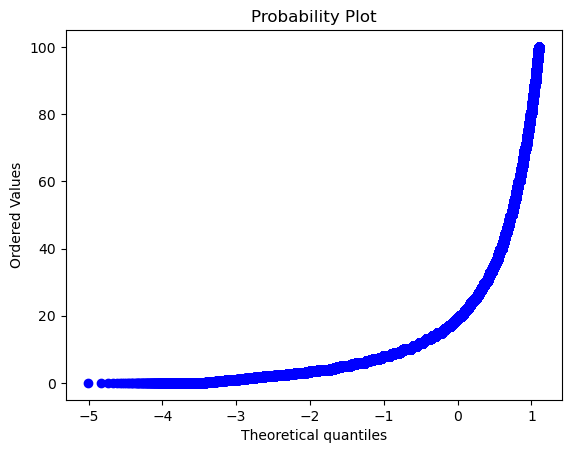

In [21]:
# Examine if product prices typically follow a normal distribution using a QQ plot. 

#import statsmodels.api as sm
#sm.qqplot(df['cleaned_prices'], line='s')

from scipy import stats
stats.probplot(df['cleaned_prices'], dist="norm", plot=plt)
plt.show

# the red line is not showing with any of the above methods (seen with Andy)